In [1]:
include("../src.jl")

itproot

(chapter_integration_adaptive)=
# Адаптивное интегрирование

Рассмотренные ранее методы интегрирования, не считая метода Гаусса, используют равномерные сетки. Взглянем на следующий пример.

(demo_adapt_badcase)=
```{proof:demo}
```
```{raw} html
<div class="demo">
```

Допустим, нам нужно проинтегрировать функцию $x \sin(2x/(x-2))$. Её график выглядит следующим образом

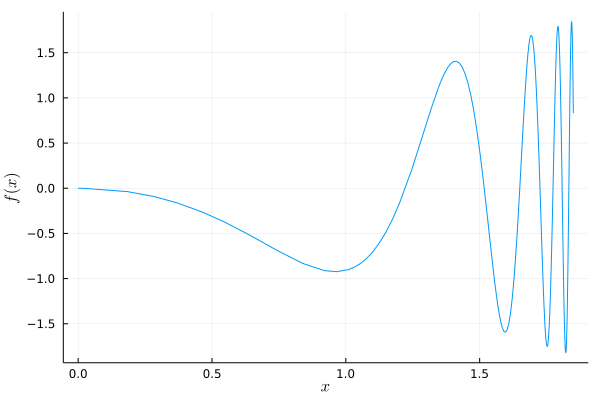

In [2]:
foo(x) = x * sin(2x/(x-2))
plot(foo, 0, 1.85; xlabel=L"x", ylabel=L"f(x)", label="")

Видно, что данная функция по-разному "изменчива" на разных участках:

- справа разрешение колебания требует мелкую сетку, причём, чем ближе к $x=2$, тем мельче;
- слева же функция меняется плавно, поэтому подойдёт и крупная сетка. 

Применение метода, основанного на равномерной сетке, при высокой точности приводит к перевычислениям.
Например, для метода Ромберга получим

In [3]:
foo(x) = x * sin(2x/(x-2))
r01 = rombergwstep(foo, 0, 1; atol=1e-6)
r12 = rombergwstep(foo, 1, 1.999; atol=1e-6)
r02 = rombergwstep(foo, 0, 1.999; atol=1e-6)
r01, r12, r02

((-0.3865423776775579, 7), (0.043384162370539096, 12), (-0.3420434608094782, 13))

`rombergwstep` отличается от {numref}`Функции {number} (romberg) <function:romberg>` только тем, что возвращает кортеж `(I[1, i], i)`. То есть, вычисления слева можно было бы закончить уже после 7 разбиений, однако при вычислении на всём участке потребовалось уже 13 разбиений.

```{raw} html
</div>
```

```{index} алгоритм; адаптивный
```
Алгоритмы, которые обнаруживают подобное поведение и подбирают сетку автоматически, называются **адаптивными**.

## Идея

Изложенную здесь идею подробнее можно почитать, например, здесь {cite}`SamarskiyGulin1989`, {cite}`fnc2017`.

Допустим, мы вычисляем часть интеграла на отрезке $\int_{x_{i-1}}^{x_i} f\diff x$. Чтобы понять, нужно ли дробить отрезок для повышения точности, можно рассмотреть два приближения интеграла и сравнить их. Если разница не удовлетворяет заданной "точности", то отрезок $[x_{i-1}, x_i]$ дробится пополам, а вычисления по *тем же* квадратурам происходят уже на более мелких отрезках.

Два приближения вычислим по формулам Симпсона {eq}`simp_final` на разных сетках

```{math}
\begin{align}
S_f(h/2) &= \frac{1}{3}\big[4T_f(h/2) - T_f(h)\big],\\
S_f(h/4) &= \frac{1}{3}\big[4T_f(h/4) - T_f(h/2)\big],\\
h &= x_i - x_{i-1}.
\end{align}
```

Всего на шаге интегрирования потребуется 5 вычислений функции $f$ в точках $x_{i-1}$, $x_{i-1} + h/4$, $x_{i-1} + h/2$, $x_{i-1} + 3h/4$, $x_i$ для получения $T_f(h)$, $T_f(h/2)$ и $T_f(h/4)$.

```{margin}
Формула Ромберга получается из экстраполяции Ричардсона.
```
Формула Симпсона имеет четвёртный порядок сходимости, а следующая за ней в экстраполяции формула Ромберга $R_f$

```{math}
R_f(h/4) = \frac{1}{15}\big[16 S_f(h/4) - S_f(h/2) \big]
```

имеет уже шестой порядок сходимости.

Приближениями $S_f(h/4)$, $R_f(h/4)$ воспользуемся для апостериорной оценки погрешности

```{math}
E = R_f(h/4) - S_f(h/4) = \frac{S_f(h/4) - S_f(h/2)}{15},
```

которую и будем использовать для критерия разбиения отрезка.

*Критерий разбиения* нужно выбирать аккуратно. Дело в том, что по значению входных данных (т.е. функции $f$ и отрезка) нельзя оценить величину интеграла: будет ли она маленькой или большой. Поэтому полагаться нужно сразу на относительную $\delta_r$ и абсолютную $\delta_a$ "точности"

```{math}
:label: int_adaptive_criterion

|E| < \delta_a + \delta_r |S_f(h/4)|.
```

Если приближение к интегралу $S_f \approx 0$ мало, то работает абсолютная погрешность $\delta_a$. Если же $S_f$ велико, то {eq}`int_adaptive_criterion` требует, чтобы разница приближений $|E|$ составляла меньше некоторой части $\delta_r$ от приближения $|S_f|$.

## Реализация

:::{proof:function} intadapt

**Адаптивное интегрирование**

```julia
"""
    intadapt(f, a, b, tol[, xtol=eps()])

Адаптивно вычисляет ∫`f`dx на отрезке [`a`, `b`]. Точность приближения `E` на подотрезке 
контролируется `tol`. Участок сетки не может быть мельче `xtol`.
Возвращает величину интеграла и сетку. Если точность не может быть достигнута,
вызывает ошибку.
"""
function intadapt(f, a, b, tol, xtol=eps(), fa=f(a), fb=f(b), m=(b-a)/2, fm=f(m))
    if a > b; a, b = b, a; end
    
    xl = (a + m)/2; fl = f(xl)  # расположение:
    xr = (m + b)/2; fr = f(xr)  # a -- xl -- m -- xr -- b
    
    T = Vector{Float64}(undef, 3)
    h = b - a
    T[1] = h * (fa + fb)/2
    T[2] = T[1]/2 + h/2 * fm
    T[3] = T[2]/2 + h/4 * (fl + fr)
    S = (4*T[2:end] - T[1:2]) / 3

    err = (S[2] - S[1]) / 15
    
    if abs(err) < tol * (1 + tol * abs(S[2]))
        Q = S[2]
        nodes = [a, xl, m, xr, b]
    else
        b - a ≤ xtol && error("Достигнут предел точности отрезка интегрирования `xtol`.")
        Ql, nodesl = intadapt(f, a, m, tol, xtol, fa, fm, xl, fl)
        Qr, nodesr = intadapt(f, m, b, tol, xtol, fm, fb, xr, fr)
        Q = Ql + Qr
        nodes = [nodesl; nodesr[2:end]]
    end
    return (Q, nodes)
end
```
:::

```{proof:demo}
```

```{raw} html
<div class="demo">
```

Посмотрим, как наш алгоритм справляется с ситуацией из {numref}`Демонстрации {number} <demo_adapt_badcase>`

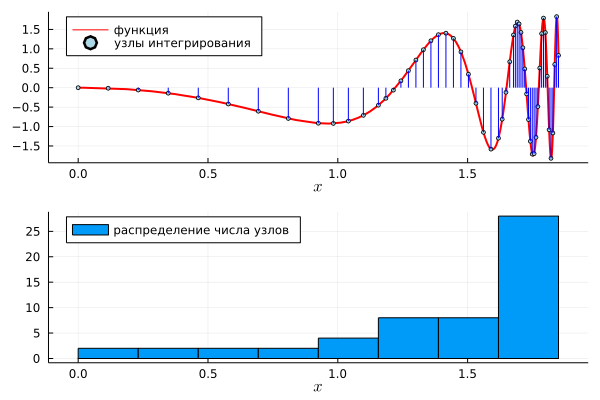

In [4]:
a, b = 0, 1.85
foo(x) = x * sin(2x/(x-2))
Q, nodes = intadapt(foo, a, b, 1e-4)
plot(; layout=(2,1), xlabel=L"x", leg=:topleft, linewidth=2)
plot!(foo, a, b; label="функция", linewidth=2, linecolor=:red)
plot!(nodes, foo.(nodes);
    label="узлы интегрирования",
    seriestype=:sticks,
    marker=(:o, 2, :lightblue),
    linecolor=:blue,
)
histogram!(nodes;
    label="распределение числа узлов",
    subplot=2,
    bins=range(a, b; length=9),
    link=:x,
)

```{raw} html
</div>
```